In [ ]:
import random
import pandas as pd
import numpy as np
import itertools
import _pickle as pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tabulate import tabulate
from imblearn import over_sampling

# Data understanding

## Read data

In [ ]:
random.seed(200)
np.random.seed(200)
path = 'ds_sample.csv'
df = pd.read_csv(path)
print(df.shape)
print(df.head())
df = df.drop('ad_id', axis=1)  # dropped ad_id - index variable (different ad_id for each row)

(4065, 18)
          ad_id  is_viewd  hour       browser  fold   site_id site_domain  \
0  1.160000e+19         0     0  facebook ios     1  85f751fd    c4e18dd6   
1  1.270000e+19         0     0  facebook ios     1  1fbe01fe    f3845767   
2  1.400000e+18         0     0  facebook ios     1  5b08c53b    7687a86e   
3  1.570000e+18         0     0  facebook ios     1  35584290    880a1c2d   
4  1.770000e+19         0     0  facebook ios     1  543a539e    c7ca3108   

  site_category   user_id device_vendor device_type connection  screen width  \
0      50e219e0  6e8b51b2      620311f4      mobile       wifi           320   
1      28905ebd  cafcf3f8      293291c1      mobile       wifi           320   
2      3e814130    667690      a25f5408      mobile       wifi           300   
3      f028772b  a53800a9      8a4875bd      mobile       wifi           320   
4      3e814130  1a625b72      85ee5f3e      mobile       wifi           320   

   ad height  load time (ms)  attempt index  

## Explore the features

In [ ]:
print(df.describe())
print('Number of unique categories in user_id:',df['user_id'].nunique())
print('Number of unique categories in site_id:',df['site_id'].nunique())
print('Number of unique categories in site_domain:',df['site_domain'].nunique())
print('Number of unique categories in site_category:',df['site_category'].nunique())
print('Number of unique categories in device_vendor:',df['device_vendor'].nunique())
# target variable
print(df['is_viewd'].value_counts())

          is_viewd         hour         fold  screen width    ad height  \
count  4065.000000  4065.000000  4065.000000   4065.000000  4065.000000   
mean      0.168512    11.126445     1.282903    318.433456    60.907749   
std       0.374366     6.000800     0.529323     16.502507    48.489564   
min       0.000000     0.000000     1.000000    216.000000    36.000000   
25%       0.000000     6.000000     1.000000    320.000000    50.000000   
50%       0.000000    11.000000     1.000000    320.000000    50.000000   
75%       0.000000    16.000000     2.000000    320.000000    50.000000   
max       1.000000    23.000000     8.000000    728.000000   480.000000   

       load time (ms)  attempt index  avg scroll depth in url  
count     4065.000000    4065.000000              4065.000000  
mean      2118.300123       1.420664                61.286101  
std        613.099724       1.325353                26.982042  
min        112.000000       0.000000                 0.000000  
25% 

In [ ]:
# features types:
df.select_dtypes(include='object')
df.select_dtypes(include='int')
df.select_dtypes(include='float64')

""
0
1
2
3
4
...
4060
4061
4062
4063


## Descriptive statistics

### Correlations

I will check multicollinearity in continuous variables

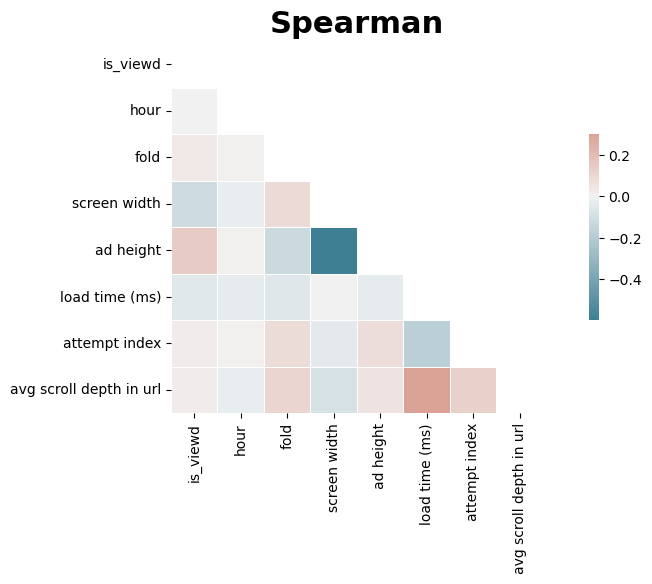

In [ ]:
df_numbers = df.select_dtypes(include='number')
df_numbers_names = df.columns.tolist()

corr = df[df_numbers_names].corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Spearman", fontsize=22, fontweight="bold")
plt.subplots_adjust(bottom=.26)
plt.show()

No high multicollinearity was observed between the continuous variables.

Next, I will check correlations between some suspicious categorial variables by cramers_v

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

print("Correlation between: site_domain & site_category is:   ", cramers_v(df['site_domain'], df['site_category']))
print("Correlation between: connection & device_type is:   ", cramers_v(df['connection'], df['device_type']))
print("Correlation between: site_id & site_domain is:   ", cramers_v(df['site_id'], df['site_domain']))
print("Correlation between: site_id & site_category is:   ", cramers_v(df['site_id'], df['site_category']))

Correlation between: site_domain & site_category is:    0.8537110706830778
Correlation between: connection & device_type is:    0.11302760754766196
Correlation between: site_id & site_domain is:    0.9592029347817741
Correlation between: site_id & site_category is:    0.9562013321755628


I can see high correlation between site_id,site_domain, site_category.
I will deal with the high correlation later in Feature Engineering.

###  Charts

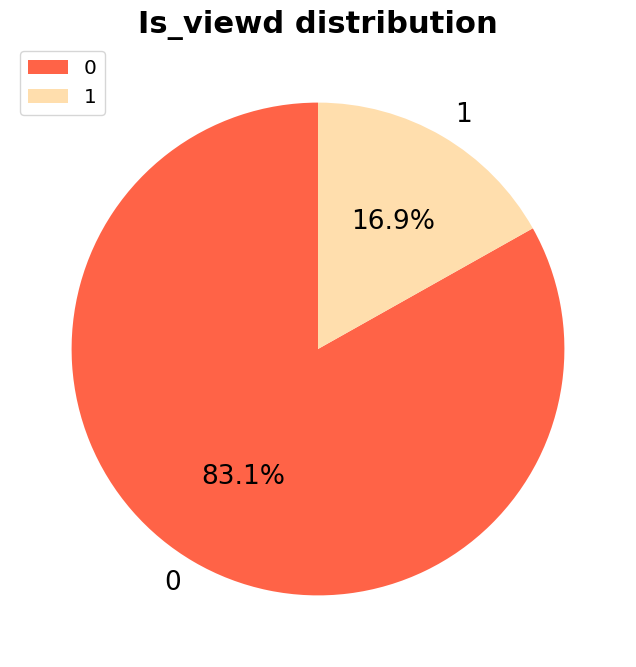

In [ ]:
# visualize frequency distribution of is_viewd variable
f = plt.subplots(1, 1, figsize=(10, 8))
df['is_viewd'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['tomato', 'navajowhite'],
                                 startangle=90, shadow=False, legend=True, fontsize=19)
plt.title('Is_viewd distribution', fontsize=22, fontweight="bold")
plt.legend(fontsize='x-large')
plt.ylabel('', fontsize=20)
plt.show()

['facebook ios', 'other browser', 'chrome', 'native app', 'safari', 'facebook android']


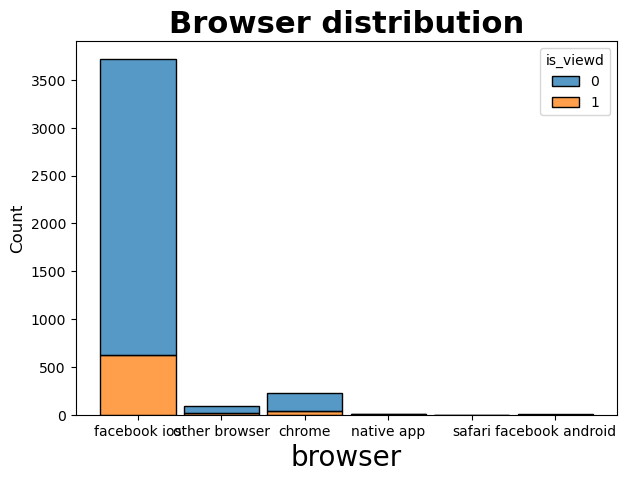

In [ ]:
# Browser vs is_viewd
browser_names = df['browser'].unique().tolist()
print(browser_names)
ax = sns.histplot(data=df, x='browser', shrink=.9, hue='is_viewd', legend='full', multiple="stack")
xlabels = browser_names
plt.xticks(range(len(browser_names)), xlabels, rotation=0)
plt.tight_layout()
plt.title('Browser distribution', fontsize=22, fontweight="bold")
plt.subplots_adjust(top=0.90)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(12)
plt.show()


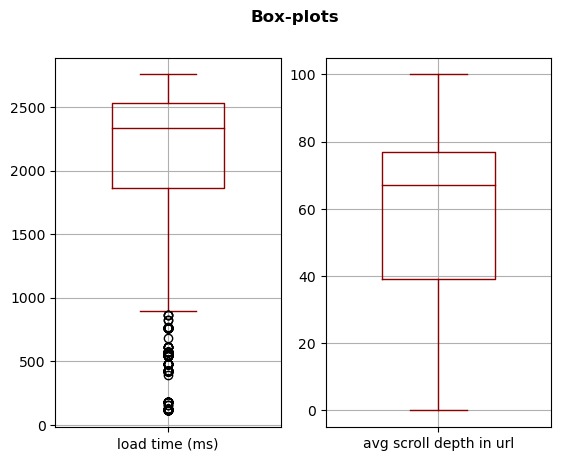

In [ ]:
# Box-plots:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Box-plots', fontweight="bold")
df.boxplot(column=['load time (ms)'], ax=axs[0], widths=(0.5), color='darkred')
df.boxplot(column=['avg scroll depth in url'], ax=axs[1], widths=(0.5), color='darkred')
plt.show()


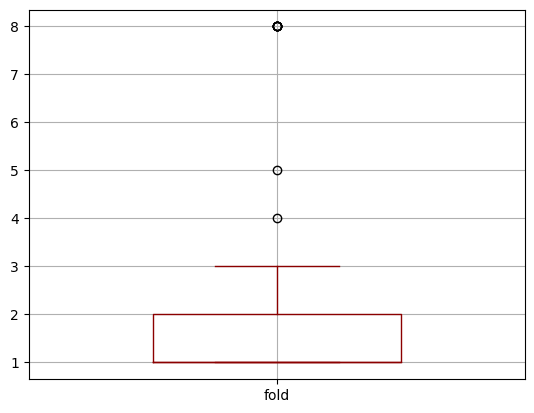

In [ ]:
# Box-plots:
# Fold Box-plots
df.boxplot(column=['fold'], widths=(0.5), color='darkred')
plt.show()

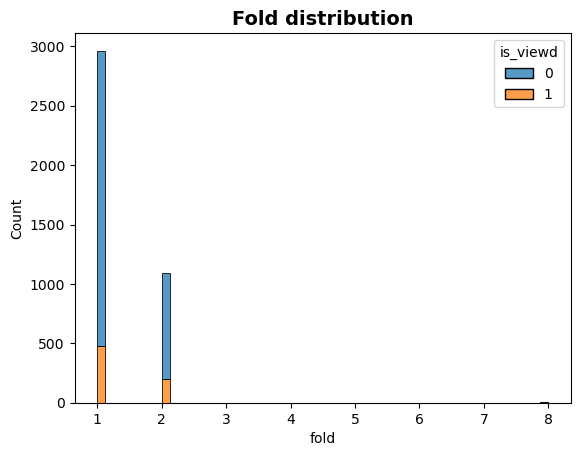

In [ ]:
g = sns.histplot(data=df, x="fold", hue="is_viewd", multiple="stack")
g.set_title('Fold distribution', fontsize=14, fontweight="bold")
plt.show()

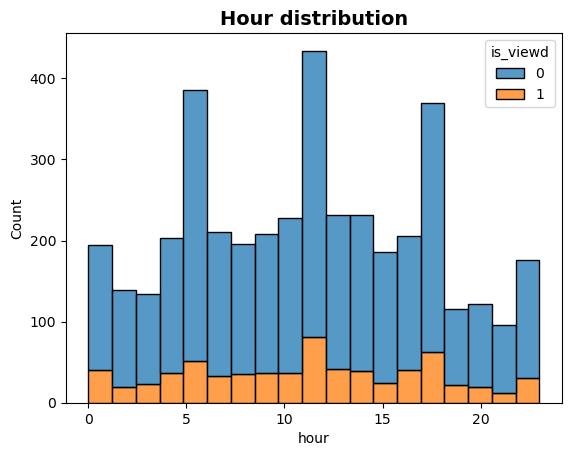

In [ ]:
g = sns.histplot(data=df, x="hour", hue="is_viewd", multiple="stack")
g.set_title('Hour distribution', fontsize=14, fontweight="bold")
plt.show()

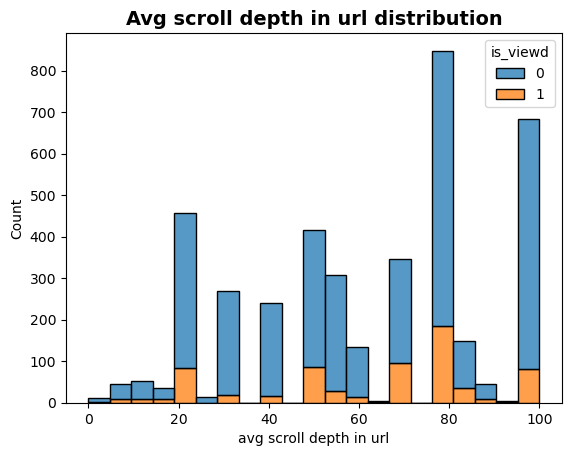

In [ ]:
g = sns.histplot(data=df, x="avg scroll depth in url", hue="is_viewd", multiple="stack")
g.set_title('Avg scroll depth in url distribution', fontsize=14, fontweight="bold")
plt.show()


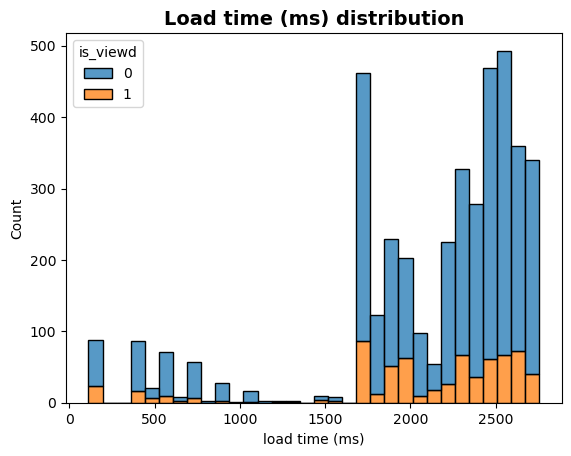

In [ ]:
g = sns.histplot(data=df, x="load time (ms)", hue="is_viewd", multiple="stack")
g.set_title('Load time (ms) distribution', fontsize=14, fontweight="bold")
plt.show()

# Data preparation
Answer: The data was not parsed, and after examination of the variable's categories I decided not to unite categories.
I did divide to bins the following variables: load time (ms), site_id, site_domain, site_category, device_vendor.

## Missing values

In [ ]:
print("Nulls:")
print(df.isnull().sum())
# This function show that there are no missing values in the data. BUT from observing the data I see sum UNKNOWN field.
print('Num of UNKNOWN in device_vendor:')
print(len(df.loc[df['device_vendor']== 'UNKNOWN']))  # 17 UNKNOWN (less than 5%), I can see that for all the
# UNKNOWN device_vendor, device_type is bot.
print('Check if for all the bot the device_vendor is UNKNOWN:')
print(df.loc[df['device_type']== 'bot']['device_vendor'].value_counts())  # for all the bot, device_vendor = UNKNOWN,
# I will relate that as a category in the device_vendor

Nulls:
is_viewd                   0
hour                       0
browser                    0
fold                       0
site_id                    0
site_domain                0
site_category              0
user_id                    0
device_vendor              0
device_type                0
connection                 0
screen width               0
ad height                  0
load time (ms)             0
attempt index              0
avg scroll depth in url    0
traffic_source             0
dtype: int64
Num of UNKNOWN in device_vendor:
17
Check if for all the bot the device_vendor is UNKNOWN:
UNKNOWN    17
Name: device_vendor, dtype: int64


## Discretization

- Binning for load time (ms) for deal with outliers.
I chose to split to equal probabilities bins. Base on the histogram, I splitted into 3 groups.

In [ ]:
df['load time (ms)'] = pd.qcut(df['load time (ms)'], q=3, labels=[1, 2, 3])  # equal distribution bins

- Fold: I chose to not 'deal' with the outliers here, because this values are reasonable and dividing
to bins here is not relevant.

- Binning for dealing with variables with a lot of categories.
I will replace all categories that their appearance in data is less than 1% to 'other',in order to avoid sparse
dummies and high variance.

In [ ]:
def values_to_replace(variable):
    value_counts = df[variable].value_counts()
    unique_value_old = df[variable].unique().tolist()
    replace_vals = []
    tr = 0.01*df.shape[0] # 1% of the DB
    for i in unique_value_old:
        if value_counts[i] < tr:
            replace_vals.append(i)
    df[variable] = df[variable].replace(replace_vals,'other')

values_to_replace('site_id')
values_to_replace('site_domain')
values_to_replace('site_category')
values_to_replace('device_vendor')

## Parse

I will check if to combine the 2 categories facebook android/ios in browser field. I tested the distribution vs is_viewd.

In [ ]:
counts = df['browser'].value_counts()
print('facebook android: \n 0:',df.loc[(df['browser']=="facebook android") & (df['is_viewd']== 0)].count()[0]/ counts['facebook android'],
      '   1: ', df.loc[(df['browser']=="facebook android") & (df['is_viewd']== 1)].count()[0]/ counts['facebook android'])
print('facebook ios: \n 0:',df.loc[(df['browser']=="facebook ios") & (df['is_viewd']== 0)].count()[0]/ counts['facebook ios'],
      '   1: ', df.loc[(df['browser']=="facebook ios") & (df['is_viewd']== 1)].count()[0]/ counts['facebook ios'])

facebook android: 
 0: 1.0    1:  0.0
facebook ios: 
 0: 0.831810854379366    1:  0.16818914562063406


The probabilities are different against the target variable, so I won't combine this two categories.

# Feature Engineering
Answer:
I removed site_category & site_id because they have high correlation with site_id.
I removed user_id because it was more like a 'index' and less explanatory (3786 different users).

## Remove variable

I saw high correlation between site_id & site_domain & site_category in part 1.3.1.
I will remove the variables with the lower correlation with the target variable (in order to avoid multicollinearity)

In [ ]:
print("Correlation between: site_id & is_viewd is:   ", cramers_v(df['site_id'], df['is_viewd']))
print("Correlation between: site_domain & is_viewd is:   ", cramers_v(df['site_domain'], df['is_viewd']))
print("Correlation between: site_category & is_viewd is:   ", cramers_v(df['site_category'], df['is_viewd']))
# Site_domain explains more about is viewd, so i remove site_category and site_id
df = df.drop('site_category', axis=1)
df = df.drop('site_id', axis=1)

# Remove user_id
df = df.drop('user_id', axis=1)


Correlation between: site_id & is_viewd is:    0.1813620776017325
Correlation between: site_domain & is_viewd is:    0.18584775992718439
Correlation between: site_category & is_viewd is:    0.11651279077480024


## Split to train & test

In order to be able to evaluate the model, I divided the data into train, test sets.

train set: 80%
test set: 20%

The train set was later used for cross validation (Grid search cross validation), hence, there was no need to create
validation set separately.

In [ ]:
y = df.pop('is_viewd')
orig_names = df.columns.tolist()  # column names before dummies
df = pd.get_dummies(df, columns=['browser', 'site_domain','device_vendor', 'device_type',
                                 'connection', 'traffic_source'])
X_train,X_test,y_train,y_test = train_test_split(df,y,test_size=0.2,random_state=0)
print(' x_train df',X_train.shape)
print(' x_test df',X_test.shape)
print(' y_train df',y_train.shape)
print(' y_test df',y_test.shape)

 x_train df (3252, 48)
 x_test df (813, 48)
 y_train df (3252,)
 y_test df (813,)


## Oversampling
Because the target variable is imbalance , I chose to over-sample the class with the lower
probability (is_viewd=1).

In [ ]:
oversample = over_sampling.RandomOverSampler()
X_train_overSample, y_train_overSample = oversample.fit_resample(X_train, y_train)
X_train, y_train = X_train_overSample, y_train_overSample
print(len(X_train), len(y_train))

5410 5410


# Classifier selection
Answer: Classifier used: a binary classifier. Supervised learning
I chose to use Random Forest because it's a model that usually reaches impressive results, even when the data set is
not large (for example this dataset probably won't be appropriate for a neural network to be able to train properly).
The random forest algorithm is known for its ability to avoid over-fitting on the data and is applicable for
categorical and continuous variables.

** Due to lack of time I fit only one model (RF), if I had more time, I would also try XGBoost, SVM and Logistic
regression and choose the best model base on the metrices.

## Random Forest
Create random search model and fit the data (by f1 measure because the data is imbalance and I assumed is meaningful
to recognize both classes and not just the accuracy).

**Accuracy better used when the class distribution is similar while F1-score is a better metric when there are
imbalanced classes as in this case.

In [ ]:
train_mode = False

In [ ]:
## Random Forest Pipe
# Hyper-parameters
n_estimators = [int(x) for x in np.linspace(start=50, stop=450, num=3)]
max_depth = [10, 30, 50, None]  # Maximum number of levels in tree
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9]  # Minimum number of samples required to split a node
random_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split}

# Create base model to tune
rf = RandomForestClassifier(oob_score=True)
rf_random = GridSearchCV(estimator=rf, param_grid=random_grid, n_jobs=1, cv=5, verbose=2, scoring='f1')
if train_mode:
    rf_random.fit(X_train, y_train)
    with open(r"RF_final_oversample.pickle", "wb") as output_file:
        pickle.dump(rf_random, output_file)  # save your model or results
else:
    with open(r"RF_final_oversample.pickle", "rb") as input_file:
        rf_random = pickle.load(input_file)  # load your model for further usage

# Best param
print('Random forest best param: ',rf_random.best_params_)

y_pred = rf_random.predict(X_test)
train_predictions = rf_random.predict(X_train)

print("End")

Random forest best param:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
End


# Results

## measurements
I chose the popular measurements in the literature:
 - Recall is important to know the rate of correctly identified positive records by the model out of all positive
records (is_viewd = 1).
 - Precision is important to know from all records the model classified as positive, how much of them are true.
 - F1 is important because it knows how to take into account both recall and precision.
 - Accuracy - records that correctly identified out of all records.
 - FP rate - important to know the proportion of negative cases incorrectly classified as positive cases in the data.

In [ ]:
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
FP_rate = fp/ (fp+tn)

In [ ]:
print(tabulate([["recall", recall], ["precision", precision],["f1_score", f1_score],
                ["accuracy", accuracy], ["FP_rate", FP_rate] ], headers=['Measure', 'Score'], tablefmt='orgtbl'))

| Measure   |    Score |
|-----------+----------|
| recall    | 0.304348 |
| precision | 0.308824 |
| f1_score  | 0.306569 |
| accuracy  | 0.766298 |
| FP_rate   | 0.139259 |


##  confusion_matrix

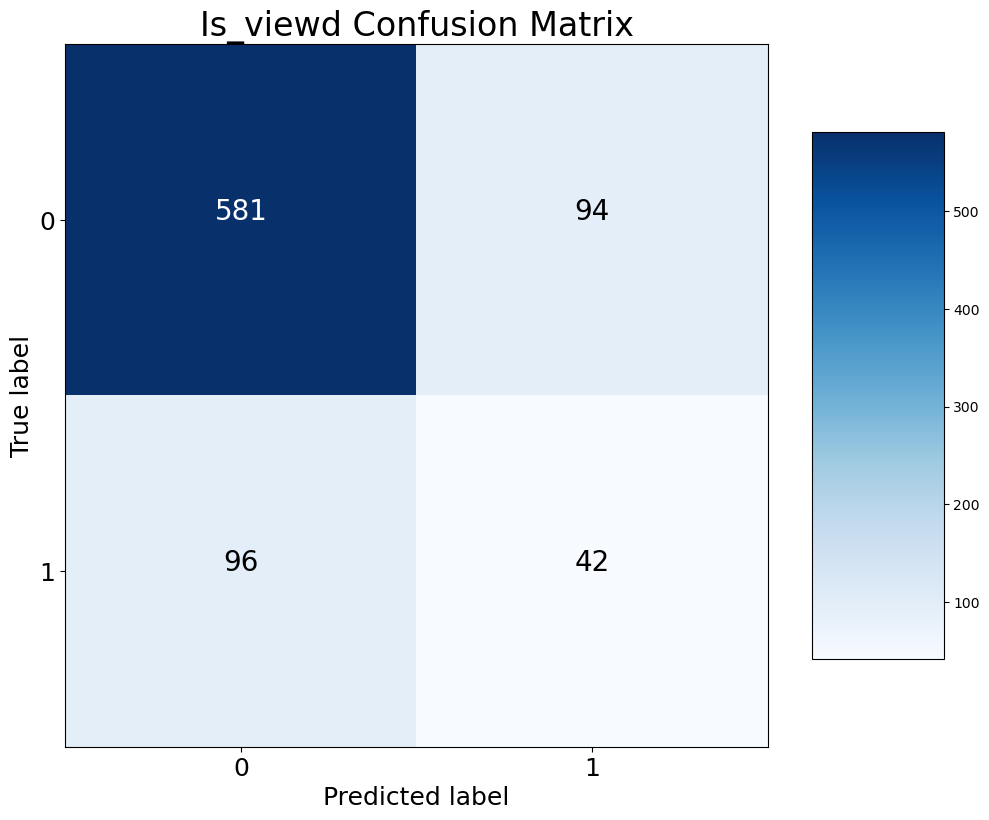

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, size=18)
    plt.yticks(tick_marks, classes, size=18)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 fontsize=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size=18)
        plt.xlabel('Predicted label', size=18)
    plt.show()
# confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['0', '1'], title='Is_viewd Confusion Matrix')

##  Feature importance

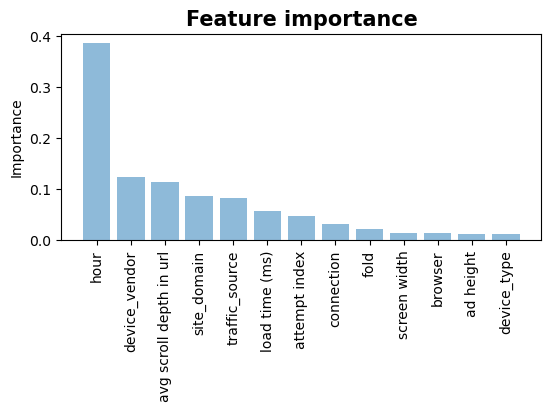

In [ ]:
feature_importance = list(zip(X_train, rf_random.best_estimator_.feature_importances_))
df_names = pd.DataFrame(feature_importance, columns=['Name', 'score'])
df_temp = pd.DataFrame(columns=orig_names)
df_temp.loc[len(df)] = 0
for i in range(df_names.shape[0]):
    name = df_names.iloc[[i]].values[0][0]
    for idx, j in enumerate(orig_names):
        if j in name:
            df_temp.iloc[0, df_temp.columns.get_loc(j)] += df_names.iloc[[i]].values[0][1]
            break
new_temp_df = df_temp.sort_values(df_temp.last_valid_index(), axis=1, ascending=[False])

# change order of columns, or plot horizontally
data = new_temp_df.iloc[0].to_dict()
names = list(data.keys())
values = list(data.values())
y_pos = np.arange(len(names))
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, names, rotation=90)
plt.ylabel('Importance')
plt.title("Feature importance", fontsize=15, fontweight="bold")
plt.subplots_adjust(left=0.15)
plt.subplots_adjust(bottom=0.45)
plt.show()

### Analysis of the results:
It can be seen that the accuracy index is relatively high, but  F1 index is significantly lower.
It can be deduced from the indices, and the confusion matrix that the model correctly classifies most of the majority
class (is_viewd=0) but does not classify the minority class (is_viewd=1) so well.


In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Avantis_assignment.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Avantis_assignment.ipynb to pdf
[NbConvertApp] Support files will be in Avantis_assignment_files/
[NbConvertApp] Making directory ./Avantis_assignment_files
[NbConvertApp] Making directory ./Avantis_assignment_files
[NbConvertApp] Making directory ./Avantis_assignment_files
[NbConvertApp] Making directory ./Avantis_assignment_files
[NbConvertApp] Making directory ./Avantis_assignment_files
[NbConvertApp] Making directory ./Avantis_assignment_files
[NbConvertApp] Making directory ./Avantis_assignment_files
[NbConvertApp] Making directory ./Avantis_assignment_files
[NbConvertApp] Making directory ./Avantis_assignment_files
[NbConvertApp] Making directory ./Avantis_assignment_files
[NbConvertApp] Making directory ./Avantis_assignment_files
[NbConvertApp] Writing 84347 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'